# 0. SETUP

## 0.1. Módulos comuns

In [1]:
from numpy import *
from numpy.linalg import *
from matplotlib.pyplot import *
from matplotlib.collections import PatchCollection
from scipy.optimize import minimize

## 0.2. Módulos do projeto

In [2]:
from project_modules import graphics    # For plots
from project_modules import graph_utils # Graph manipulation
from project_modules import model_math  # The mathematical functions of the model

## 0.2. Parâmetros do problema

In [36]:
SCALE = 1.0        # How much each screen element is going to be scaled. Default is 1.0
SCREEN_HEIGHT = 30 # The height of the screen that contains the overlapping windows in pixels
SCREEN_WIDTH = 30  # The width of the screen that contains the overlapping windows in pixels
MAX_WINDOW_DIM = 3 # The max height or width each window can have. For the project the default is 3.
MIN_WINDOW_DIM = 2 # The minimum height or width each window can have. For the project the default is 2.
CLUSTER_DISTANCE_FROM_SCREEN_CENTER = 6 # The distance from the clusters to the screen center in pixels
POINT_DISTANCE_FROM_CLUSTER = 2         # How far the points can be from the cluster in pixels
KNN_K = 1         # The number of closest neighbors considered for building the connectivity graph
ALPHA = 0.1       # The weighting value for the energy function between E_N and E_O
SEED = 1.0        # Seed used for random numbers generation

## 0.3. Preprocessamento dos parâmetros

In [37]:
# Rescale
SCREEN_HEIGHT *= SCALE
SCREEN_WIDTH *= SCALE
MAX_WINDOW_DIM *= SCALE
MIN_WINDOW_DIM *= SCALE
CLUSTER_DISTANCE_FROM_SCREEN_CENTER *= SCALE
POINT_DISTANCE_FROM_CLUSTER *= SCALE
# Compute screen center
SCREEN_CENTER = array([ floor(SCREEN_WIDTH/2), floor(SCREEN_HEIGHT/2) ])
# Set a seed for reproducibility purposes
#random.seed(7)
random.seed(1)

# 1. PREPARAÇÃO DOS DADOS

Os vetores $P_j$ gerados possuem dimensão $4$: a posição $x$ e $y$ (coluna) da origem do retângulo (ponto superior esquerdo), a altura do retângulo $h$ e a largura $w$, e o cluster $c_j$ ao qual ele pertence, de forma que $P_j=(x_j,y_j,h_j,w_j, c_j)$.

## 1.1 Gerar Centros

In [38]:
n_groups = random.randint(3,7)
angle_between_points = (2.0 * pi / n_groups * arange(0 , n_groups)) # The array of the angle of each cluster w.r.t. the x-axis
clusters = transpose( # Each row is a pair x,y from each cluster
    array( [
        CLUSTER_DISTANCE_FROM_SCREEN_CENTER * cos( angle_between_points ) + SCREEN_CENTER[0],
        CLUSTER_DISTANCE_FROM_SCREEN_CENTER * sin( angle_between_points ) + SCREEN_CENTER[1]
    ] )
)

## 1.2 Gerar pontos ao redor dos centros

In [39]:
size_groups = random.randint(5, 16, n_groups)
points = zeros((sum(size_groups),5)) # [x, y, w, h, label]
j = 0
for cluster_idx in range(n_groups):
    for idx in range(size_groups[cluster_idx]):
        # Point position
        points[j,:2] = clusters[cluster_idx] + random.randint(-POINT_DISTANCE_FROM_CLUSTER,POINT_DISTANCE_FROM_CLUSTER, 2)
        # Point dimension
        points[j,2:4] = random.randint(MIN_WINDOW_DIM,MAX_WINDOW_DIM+1,2)
        # cluster_information
        points[j,4] = cluster_idx
        j += 1
        
points_pos = points[:,:2] # position vectors
points_dims = points[:,2:4] # dimension vectors

## 1.3 Mostrar os dados

<Figure size 432x288 with 0 Axes>

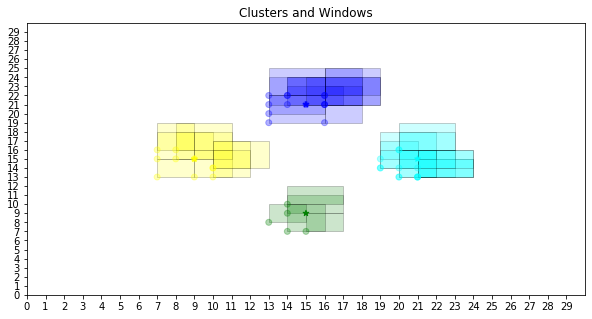

In [40]:
graphics.draw_windows(clusters, points_pos, points_dims, points[:,4], n_groups, size_groups, SCREEN_HEIGHT, SCREEN_WIDTH, SCALE)

# 2. Modelagem Matemática


O problema se resume a minimizar $E(X) = (1-\alpha) E_O(X) + \alpha E_N(X) $, em que $X=(x_j, y_j)$ e $\alpha \in [0,1]$. $E_0$ e $E_N$ são as funções de energia de overlap e a de relação entre os vizinhos. Mais detalhes sobre as funções podem ser encontradas [neste link](https://ieeexplore.ieee.org/abstract/document/6629989).

In [41]:
_LAPLACIAN_L = graph_utils.laplacian_graph(points_pos, K=KNN_K)
_DELTA_X = _LAPLACIAN_L.dot(points_pos[:,0])
_DELTA_Y = _LAPLACIAN_L.dot(points_pos[:,1])
def E_N(X):
    w = X[-1]
    X = reshape(X[:-1], (points.shape[0], 2)) # Removes w from the state
    e_n = model_math.E_N(X, w, _LAPLACIAN_L, _DELTA_X, _DELTA_Y)
    return e_n

def E_O(X):
    X = reshape(X[:-1], (points.shape[0], 2)) # Remove w from the state
    e_o = model_math.E_O(X, points_dims)
    return e_o

# 3. Solução Numérica

## 3.1 Função

In [42]:
alpha = ALPHA

def f (X):
    e_n = E_N(X)
    e_o = E_O(X)
    return alpha * e_n + (1.0- alpha) * e_o

def jac_f(X):
    w = X[-1]
    X = reshape(X[:-1], (points.shape[0], 2))
    jac_E_O = model_math.jac_E_O(X, points_dims)
    jac_E_N = model_math.jac_E_N(X[:,0], X[:,1], w, _LAPLACIAN_L, _DELTA_X, _DELTA_Y)
    jac_E = alpha * jac_E_N + (1.0-alpha) * jac_E_O
    return jac_E

"""
_HESS_E_N = model_math.hess_E_N(_LAPLACIAN_L, _DELTA_X, _DELTA_Y)
def hess_f(X):
    w = X[-1]
    X = reshape(X[:-1], (points.shape[0], 2))
    H_E_N = _HESS_E_N
    H_E_O = model_math.hess_E_O(X[:,0], X[:,1], points_dims[:,0], points_dims[:,1])
    H = alpha * H_E_N + (1.0-alpha) * H_E_O
    return H
"""

'\n_HESS_E_N = model_math.hess_E_N(_LAPLACIAN_L, _DELTA_X, _DELTA_Y)\ndef hess_f(X):\n    w = X[-1]\n    X = reshape(X[:-1], (points.shape[0], 2))\n    H_E_N = _HESS_E_N\n    H_E_O = model_math.hess_E_O(X[:,0], X[:,1], points_dims[:,0], points_dims[:,1])\n    H = alpha * H_E_N + (1.0-alpha) * H_E_O\n    return H\n'

## 3.2 Restrições

A implementação das restrições foi adapatada para as condições do SciPy nas quais as desigualdades são do tipo $r_i(X) \geq 0$ [(fonte)](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize).

In [43]:
x_min = 0; x_max = SCREEN_WIDTH
y_min = 0; y_max = SCREEN_HEIGHT

# r1: x_min-x_i <= 0 <=> x_i - x_min >= 0
def constr_fun_1(X):
    X = reshape(X[:-1], (points.shape[0], 2)) # Remove w from the state
    return model_math.constr_fun_1(X, x_min)

# r2: x_i - x_max + h_i <= 0 <=> x_max - x_i - h_i >= 0
def constr_fun_2(X):
    X = reshape(X[:-1], (points.shape[0], 2)) # Remove w from the state
    return model_math.constr_fun_2(X, x_max, points_dims)

# r3: y_min-y_i <= 0 <=> y_i - y_min >= 0
def constr_fun_3(X):
    X = reshape(X[:-1], (points.shape[0], 2)) # Remove w from the state
    return model_math.constr_fun_3(X, y_min)

# r4: y_i - y_max + v_i <= 0 <=> y_max - y_i - v_i >= 0
def constr_fun_4(X):
    X = reshape(X[:-1], (points.shape[0], 2)) # Remove w from the state
    return model_math.constr_fun_4(X,y_max, points_dims)

constrs = (
    {'type': 'ineq', 'fun':  constr_fun_1},
    {'type': 'ineq', 'fun':  constr_fun_2},
    {'type': 'ineq', 'fun':  constr_fun_3},
    {'type': 'ineq', 'fun':  constr_fun_4},
)

## 3.3 Minimização

In [44]:
list_energy_overlapping = []
list_energy_neighborhood = []
list_energy = []
# Stores the energy computed for each iteration
def iter_callback(xk):
    list_energy_overlapping.append(E_O(xk))
    list_energy_neighborhood.append(E_N(xk))
    list_energy.append(f(xk))
    print(list_energy[-1])
    return

In [45]:
w_init = 1.0
X_init = append(points_pos.flatten(), [w_init])

# Minimizer 
use_grad = True
use_cons = True
res = None

method = 'SLSQP'
maxiter = 1e3
cons = None
if(use_cons):
    cons = constrs

if(use_grad):
    res = minimize(
        f, X_init, 
        method=method, 
        jac=jac_f,
        #hess=hess_f,
        constraints=cons, 
        tol=1e-10, 
        options={"maxiter" : maxiter},
        callback=iter_callback
    )
else:
    res = minimize(
        f, X_init, 
        method=method, 
        constraints=cons, 
        tol=1e-9, 
        options={"maxiter" : maxiter},
        callback=iter_callback
    )
print(res)
X_final = reshape(res["x"][:-1], (points.shape[0], 2))

163.79087702313865
5264.175159863472
2555.6416853907854
1966.160690580644
1812.6801344319306
1958.1036401521324
1697.3195768670432
1866.9198151728187
2126.021495770717
2217.2183069613357
2241.2054716287757
2217.3451678926326
2244.8438426266102
2213.198977019637
2290.603873406252
2334.9989947047025
2254.0237869271086
2449.9485133428257
2129.556600632943
2551.021684767691
2387.338560599205
2105.0446725776965
2314.896397082203
2457.754798681427
2182.550312431282
2263.8150569228824
2145.4790576875516
2007.037652515026
2182.116866808649
2085.7883072221616
1928.6764167815325
1845.8068274901755
1806.5594068051928
1776.0813822855644
1816.6235160215988
1625.8813143925024
1629.598824952016
1596.018150533181
1644.2633418036107
1636.0683926317772
1662.1431718091978
1657.7654261599082
1645.7401156682834
1737.8050099455834
1746.0938532049431
1745.0290843718915
1689.741820221034
1726.6181295472218
1650.867441466083
1685.7634435354232
1682.6520960306907
1698.468365590449
1592.67536150383
1858.80626561

900.374790558325
894.6038964675826
888.9298527727822
882.5209791018126
876.7403090273631
869.9284125649749
864.786756295009
856.956808567855
854.7272779259415
845.0420846941882
841.1678011395693
834.5265859972773
829.24087134613
821.8579159390118
813.2846604819707
809.7149771645758
798.4083192108579
798.5142302879432
783.2609783393353
788.8431101492934
768.3867440973022
780.6625272590924
754.3288675163677
773.3540381685242
742.2763947483375
765.062848850919
733.3176001927371
754.4461909282127
727.2831836303664
742.9552299961878
722.7991955704882
733.5870117590516
720.420365744963
724.5996770557158
715.6050108338043
717.64417573026
711.1578130853112
712.0003097999053
707.1066657327284
707.306034111942
703.4317662867178
702.5267477847528
699.4648779454625
698.4251025710926
695.8632275483311
694.8462163157826
689.7469043194438
686.3000922678565
683.6173681320521
682.1807862702939
679.9193401386625
679.1816904691673
677.4861180180137
677.2189959609987
676.0020653467528
676.0188217841435
67

213.60069844989644
211.60362877397174
212.25304592039623
209.96199899653342
210.85167974967382
208.3395899102867
209.363268544117
206.36458012790996
206.61754709996566
203.6872085067429
202.9331518131004
199.8375403923188
198.9169704467392
194.50169295713607
194.2824641418041
187.63007322185254
189.5822315918491
181.17342469750005
185.8720985626269
177.96252559815377
179.0932658630424
176.62687188222574
170.53777477384673
177.5374985603464
163.0283495452607
171.80870587744465
155.32667150403736
161.21770097947612
148.5503387177508
151.07497757242936
142.16839168430133
142.86834568734363
135.91697050477705
136.11734119252299
129.87938253854995
130.60806646740855
124.34742407692747
125.7641132790002
119.65694388491968
121.23940473634053
115.07841009593375
115.93645118622004
110.36367392943752
109.96054196176226
106.13894404146451
104.26999090706289
102.58378018774457
98.95464879539571
99.84631369514379
93.78056962040971
98.178217499621
88.76589905723606
97.50236509498855
84.5888330247527

# 4. Visualização dos Resultados

## Disposição final das janelas

<Figure size 432x288 with 0 Axes>

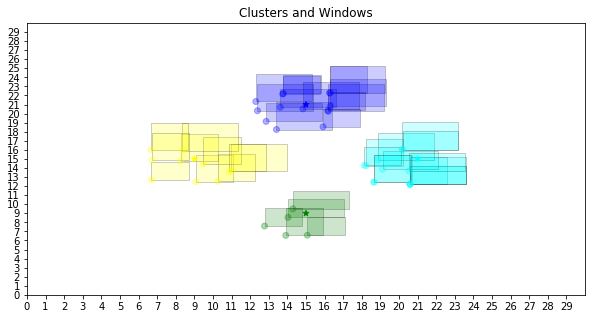

In [46]:
graphics.draw_windows(clusters, X_final, points_dims, points[:,4], n_groups, size_groups, SCREEN_HEIGHT, SCREEN_WIDTH, SCALE)
#ylim([-20, 50])
#xlim([-20, 50])

## Comportamento das funções de energia

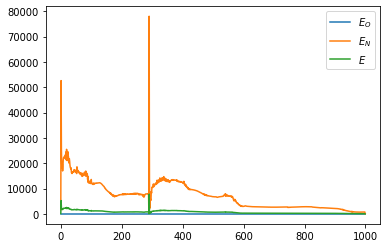

In [47]:
clf()
#ylim([0, 0.9])
plot(list_energy_overlapping, label=r"$E_O$")
plot(list_energy_neighborhood, label=r"$E_N$")
plot(list_energy, label=r"$E$")
legend()
show()

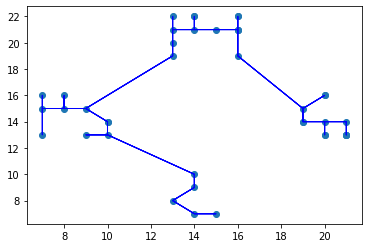

In [48]:
G = graph_utils.adjacency_matrix(points_pos, KNN_K)
graph_utils.connectivity_scatter(points_pos,G)

array([-1.        , -0.5       , -0.33333333, -0.25      ,  0.        ,
        1.        ])

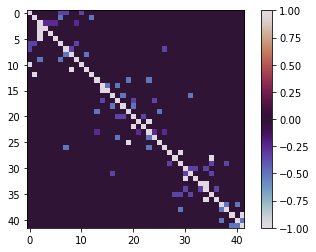

In [49]:
rcParams["image.cmap"] = 'twilight'
#rcParams["image.cmap"] = 'jet'
fig, ax = subplots()
aa = ax.imshow(_LAPLACIAN_L) #- _LAPLACIAN_L.transpose())
cbar = fig.colorbar(aa)
unique(_LAPLACIAN_L)

In [17]:
print(res["x"][-1])

1.7500049238745212


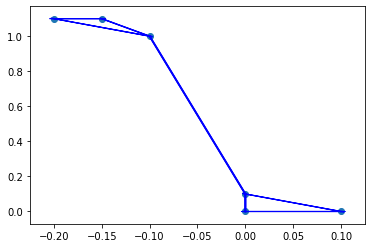

In [18]:
rcParams["image.cmap"] = 'plasma'
ps = array([
    [-0.2, 1.1], #1
    [-0.15, 1.1], # 2
    [-0.1, 1.0], # 3
    [0.,0.],   # 4
    [0., 0.1], # 5
    [0.1, 0.] # 6
])
G = graph_utils.adjacency_matrix(ps, 2)
graph_utils.connectivity_scatter(ps,G)

[[ 1.         -0.5        -0.5         0.          0.          0.        ]
 [-0.5         1.         -0.5         0.          0.          0.        ]
 [-0.33333333 -0.33333333  1.          0.         -0.33333333  0.        ]
 [ 0.          0.          0.          1.         -0.5        -0.5       ]
 [ 0.          0.         -0.33333333 -0.33333333  1.         -0.33333333]
 [ 0.          0.          0.         -0.5        -0.5         1.        ]]


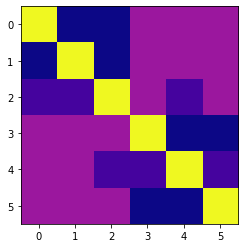

In [19]:
L = graph_utils.laplacian_graph(ps, 2)
imshow(L)
print(L)